# Grover's Search
Author: Selman Özleyen

## Setup

In [1]:
# initializations for utils
import matplotlib.pyplot as plt
import numpy as np

# importing qiskit
from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit

# import basic plot & visualization tools
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram, array_to_latex

In [2]:
def init_s(qc, qubits):
    """
    Apply H gate to the qubits to 
    initialize with the superposition
    """
    for q in qubits:
        qc.h(q)
    return qc

In [3]:
def create_Us(nqubits, draw=False):
    """
    The transformation:
        Us = 2|s><s| - 1
    written in quantum circuits.
    """
    
    qc = QuantumCircuit(nqubits)
    
    # |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # To flip the phase except |11..1>
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  
    qc.h(nqubits-1)
    
    # |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        
    Us = qc.to_gate()
    Us.name = "$U_s$"
    
    if draw:
        return qc.draw()
    return Us

### Oracles

In [4]:
def example_Uw1(nqubits, draw=False):
    qc = QuantumCircuit(nqubits)
    qc.cz(0,1)
    Uw = qc.to_gate()
    Uw.name = "$U_w$"
    if draw:
        return qc.draw()
    return Uw

In [5]:
def example_Uw2(nqubits, draw=False):
    qc = QuantumCircuit(nqubits)
    qc.ccz(0,1,2)
    Uw = qc.to_gate()
    Uw.name = "$U_w$"
    if draw:
        return qc.draw()
    return Uw

## Example 1: Multiple Solutions

We will first consider the case where there are multiple solutions for our search. Let those elements be 3 and 7 from integers between 0 to 7. These will be represented as $|011\rangle$ and $|111\rangle$ states.

With multiple solutions applying Grover's iterations the same way will still work. But our calculation to find the number of iterations need a little change. The equation for finding the number of optimal iterations is still the same:

$$r \approx \frac{\pi}{4 \theta}$$ 

But the way we find $\theta$ can be generalized with the following equation

$$\theta=2\arcsin\sqrt{\frac{M}{N}}$$

where $M$ is the number of solutions and $N$ is the number of elements in our database.

In [6]:
def print_prob(M,N):
    θ = np.arcsin(np.sqrt(M/N))*2
    r=np.ceil(np.pi/(4*θ))
    opt_val = np.sin(θ*(r+1.0/2))**2
    print("Theta: ",θ,"No. of iterations: ",r,"Approx. Success prob.: ",opt_val)

In [7]:
M=2.0
N=8.0
print_prob(M,N)


M=1.0
N=8.0
print_prob(M,N)

Theta:  1.0471975511965979 No. of iterations:  1.0 Approx. Success prob.:  1.0
Theta:  0.7227342478134157 No. of iterations:  2.0 Approx. Success prob.:  0.9453124999999999


### Creating the circuit

In [8]:
n = 3 # number of qubits
grover_circuit = QuantumCircuit(n)

### Initializing superposition

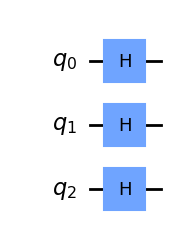

In [9]:
init_s(grover_circuit, range(n))
grover_circuit.draw()

### Creating the oracle

Let's see how it looks as a circuit. Which is a Controlled-Z gate on 0 and 1.

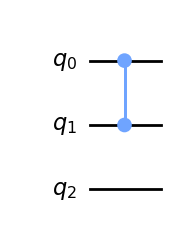

In [10]:
example_Uw1(n,draw=True)

In [11]:
Uw = example_Uw1(n)

### $U_w$ as a matrix
we can confirm that our oracle will accept the states $|011\rangle$ and $|111\rangle$

In [12]:
array_to_latex(qi.Operator(Uw))

<IPython.core.display.Latex object>

### Adding the oracle to the circuit

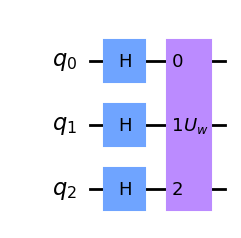

In [13]:
grover_circuit.append(Uw, range(n))
grover_circuit.draw()


### Circuit of $U_s$ 

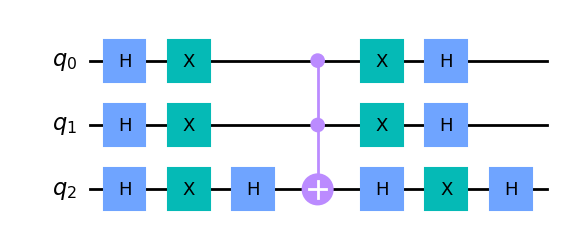

In [14]:
create_Us(n,True)

### Adding $U_s$

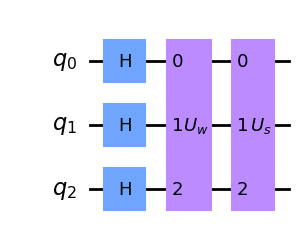

In [15]:
grover_circuit.append(create_Us(n),range(n))
grover_circuit.draw()

### Final look of the circuit

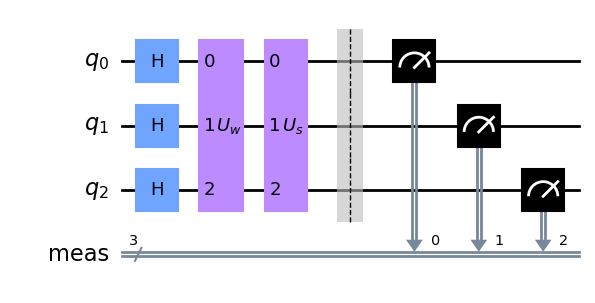

In [16]:
grover_circuit.measure_all()
grover_circuit.draw()

### Simulating the circuit

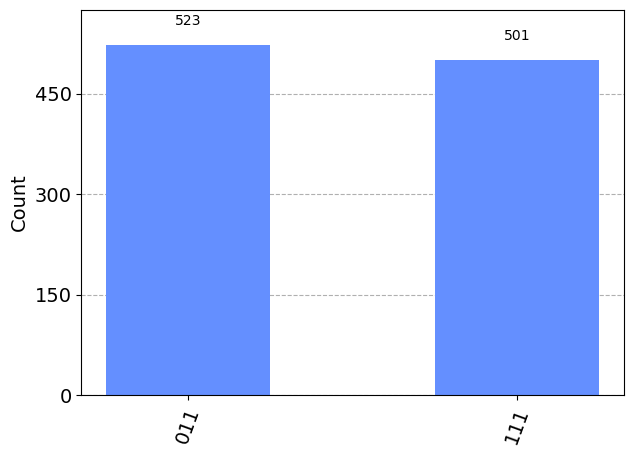

In [17]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


## Example 2: One solution, multiple iterations

This time let us search for the element 7 from integers between 0 to 7. This will be represented as the $|111\rangle$ state.

In [18]:
n=3
grover_circuit = QuantumCircuit(n)

### The Oracle

Let's see how it looks as a circuit.

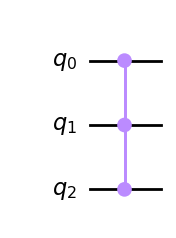

In [19]:
example_Uw2(n,draw=True)

### $U_w$ as a matrix
we can confirm that our oracle will accept the state $|111\rangle$.

In [20]:
Uw = example_Uw2(n)
array_to_latex(qi.Operator(Uw))

<IPython.core.display.Latex object>

### Writing the algorithm

In [21]:
init_s(grover_circuit, range(n)) # initialization to superposition
for i in range(2): # grover iterations
    grover_circuit.append(example_Uw2(n), range(n)) # add Uw
    grover_circuit.append(create_Us(n),range(n)) # add Us

### Final look of the circuit

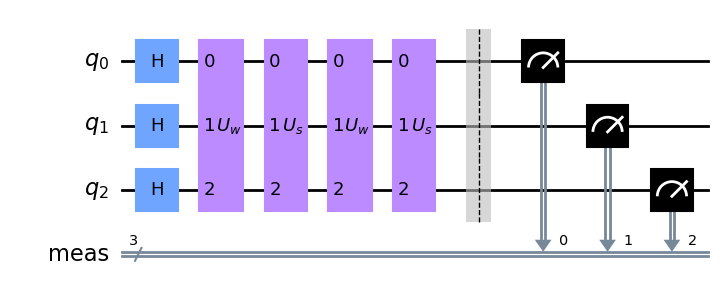

In [22]:
grover_circuit.measure_all()
grover_circuit.draw()

### Simulating the circuit

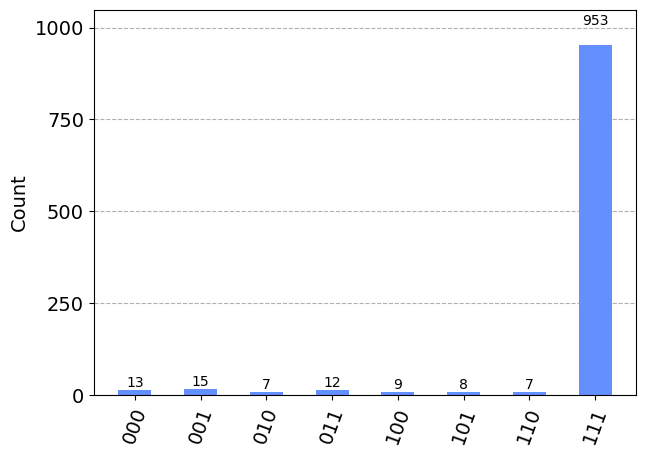

In [23]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


## References/Credits

Some code snippets are from the following web pages:
- https://qiskit.org/textbook/ch-algorithms/grover.html#Contents
- https://you.stonybrook.edu/qcomputing/2018/07/18/2-3-qubit-grovers-algorithm/
